In [1]:
! pip install scipy

Solving eigenproblem (this can be the slow step)...


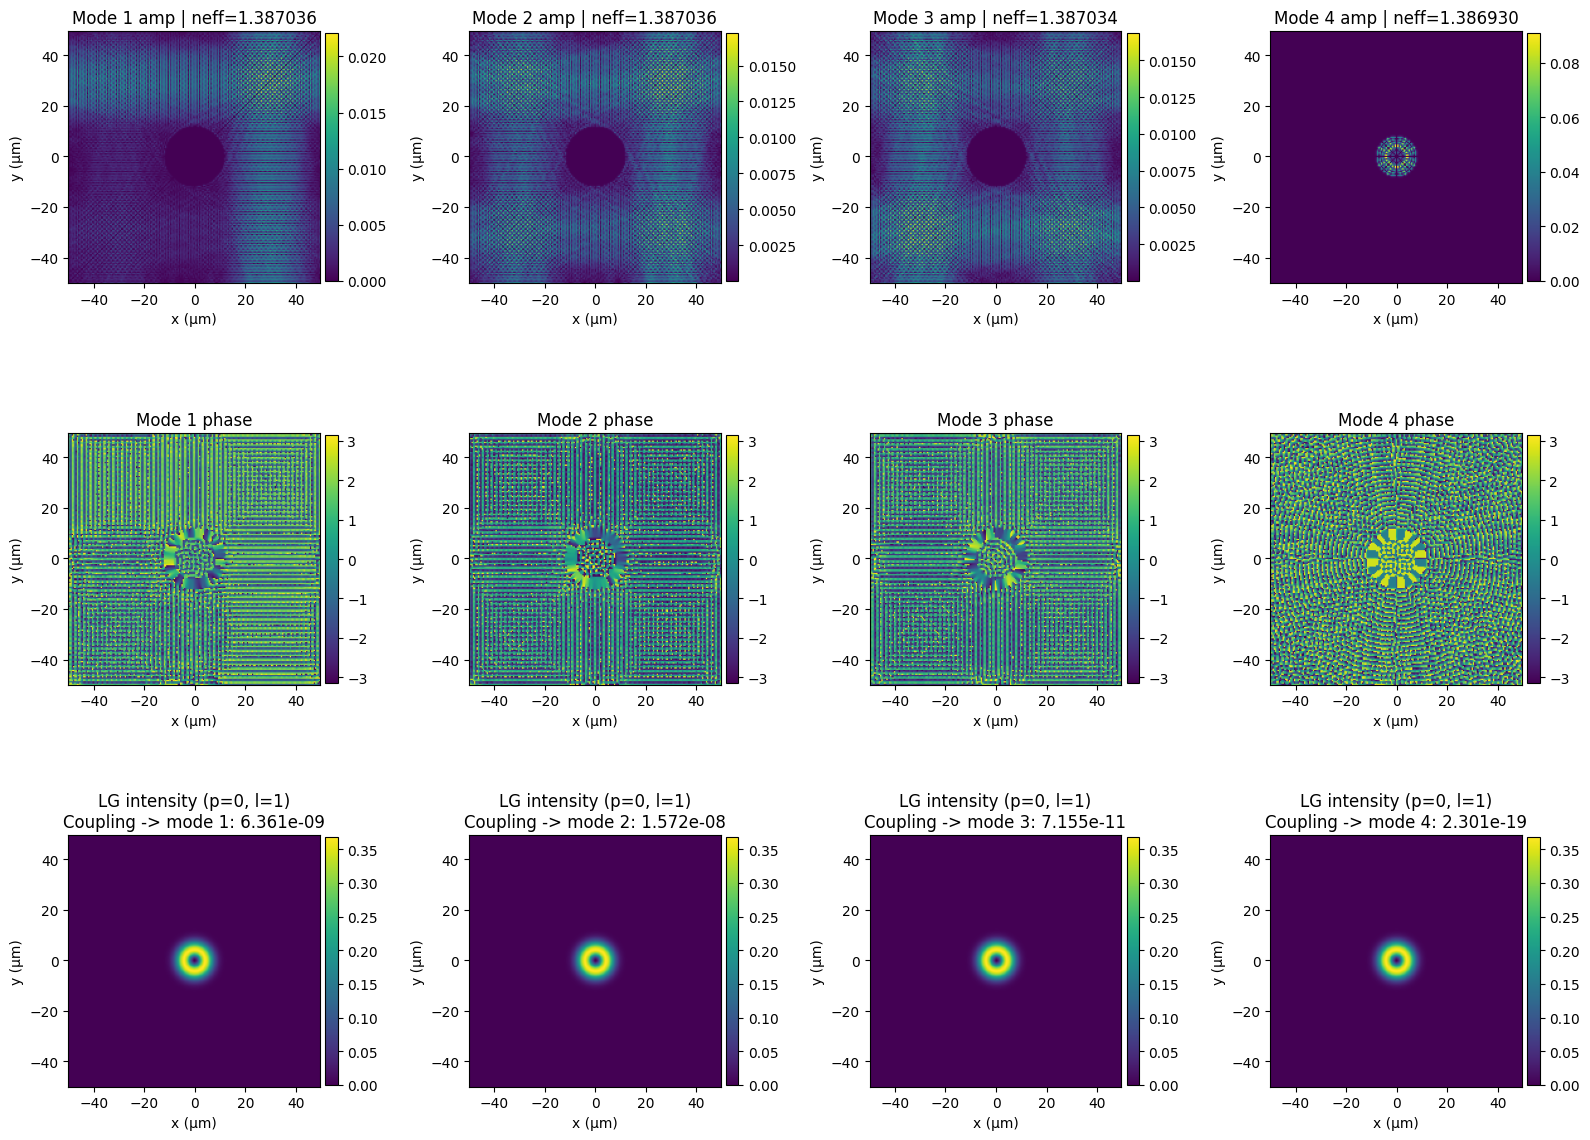

Computed effective indices (neff) and coupling fractions to LG beam:
Mode 1: neff = 1.387036  imag = -8.928e-05  | coupling = 6.361e-09
Mode 2: neff = 1.387036  imag = -9.041e-05  | coupling = 1.572e-08
Mode 3: neff = 1.387034  imag = -9.050e-05  | coupling = 7.155e-11
Mode 4: neff = 1.386930  imag = -4.094e-15  | coupling = 2.301e-19
Saved figure and arrays to fdfd_pml_overlap_outputs


In [7]:
# fdfd_pml_lg_overlap.py
# Scalar 2D FDFD solver (Ez-like) with lossy PML approx and LG overlap calculation.

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import eigs
from scipy.special import genlaguerre
from scipy.sparse import eye, diags, kron
import os, math

wavelength = 800e-9
c0 = 299792458.0
k0 = 2 * np.pi / wavelength


nx, ny = 200, 200
physical_size = 100e-6
dx = physical_size / nx
dy = physical_size / ny

r_inner = 8e-6
r_outer = 12e-6


n_out = 1.33
n_wall = 1.46
n_core = 1.33


pml_thickness = 12
pml_max_sigma = 80.0


lg_p = 0
lg_l = 1
w0 = 6e-6
beam_offset = (0.0, 0.0)


nev = 4
target_near = n_wall * 0.95
sigma = (k0 * target_near)**2
maxiter = 1000
tol = 1e-5


x = (np.arange(nx) - nx//2) * dx
y = (np.arange(ny) - ny//2) * dy
X, Y = np.meshgrid(x, y, indexing='xy')
R = np.sqrt(X**2 + Y**2)

eps = np.ones((ny, nx)) * n_out**2
eps[(R >= r_inner) & (R <= r_outer)] = n_wall**2
eps[R < r_inner] = n_core**2


sigma_x = np.zeros(nx)
sigma_y = np.zeros(ny)
grad_order = 2.0
for i in range(pml_thickness):
    frac = ((pml_thickness - i) / pml_thickness)**grad_order
    sigma_val = pml_max_sigma * frac**2
    sigma_x[i] = sigma_val
    sigma_x[-1 - i] = sigma_val
    sigma_y[i] = sigma_val
    sigma_y[-1 - i] = sigma_val

Sigma = np.zeros_like(eps)
for j in range(ny):
    for i in range(nx):
        Sigma[j, i] = sigma_x[i] + sigma_y[j]


omega = 2 * np.pi * c0 / wavelength
eps0 = 8.854187817e-12
eps_complex = eps.astype(np.complex128) * (1 - 1j * Sigma / (omega * eps0 + 1e-30))


nxny = nx * ny
eps_flat = eps_complex.ravel()

def laplacian_2d(nx, ny, dx, dy):
    ex = np.ones(nx)
    Dx = diags([ex, -2*ex, ex], offsets=[-1, 0, 1], shape=(nx, nx)) / dx**2
    ey = np.ones(ny)
    Dy = diags([ey, -2*ey, ey], offsets=[-1, 0, 1], shape=(ny, ny)) / dy**2
    Ix = eye(nx); Iy = eye(ny)
    L = kron(Iy, Dx) + kron(Dy, Ix)
    return L.tocsr()

L = laplacian_2d(nx, ny, dx, dy)

A = -L + diags((k0**2) * eps_flat, 0, format='csr')

print("Solving eigenproblem (this can be the slow step)...")
eigvals, eigvecs = eigs(A, k=nev, sigma=sigma, which='LM', tol=tol, maxiter=maxiter)


order = np.argsort(-np.real(eigvals))
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

beta2 = eigvals
beta = np.sqrt(beta2)
neff = beta / k0


def LG_field(p, l, r, phi, w0):
    rho = np.sqrt(2) * r / w0
    radial = np.exp(-rho**2/2) * (rho**abs(l))
    if p > 0:
        Lpl = genlaguerre(p, abs(l))(rho**2)
        radial *= Lpl
    az = np.exp(1j * l * phi)
    return radial * az

Xb = X - beam_offset[0]
Yb = Y - beam_offset[1]
Rb = np.sqrt(Xb**2 + Yb**2)
Phib = np.arctan2(Yb, Xb)
E_lg = LG_field(lg_p, lg_l, Rb, Phib, w0)
dA = dx * dy


E_lg_flat = E_lg.ravel()
P_lg = np.vdot(E_lg_flat, E_lg_flat) * dA
E_lg_norm = E_lg_flat / np.sqrt(P_lg + 1e-30)

couplings = []
for i in range(eigvecs.shape[1]):
    mode = eigvecs[:, i]
    P_mode = np.vdot(mode, mode) * dA
    mode_norm = mode / np.sqrt(P_mode + 1e-30)
    overlap = np.vdot(mode_norm.conj(), E_lg_norm) * dA
    coupling = np.abs(overlap)**2
    couplings.append(coupling.real)

num_plot = min(4, eigvecs.shape[1])
fig, axs = plt.subplots(3, num_plot, figsize=(4*num_plot, 12))
axs = np.atleast_2d(axs)

axs[0,0].imshow(np.real(eps_complex), extent=[x[0]*1e6, x[-1]*1e6, y[0]*1e6, y[-1]*1e6], origin='lower')
axs[0,0].set_title('Re(eps) (with PML imaginary part)')
axs[0,0].set_xlabel('x (µm)'); axs[0,0].set_ylabel('y (µm)')

for i in range(num_plot):
    mode2d = eigvecs[:, i].reshape((ny, nx))
    amp = np.abs(mode2d)
    ph = np.angle(mode2d)
    im1 = axs[0, i].imshow(amp, extent=[x[0]*1e6, x[-1]*1e6, y[0]*1e6, y[-1]*1e6], origin='lower')
    axs[0, i].set_title(f'Mode {i+1} amp | neff={neff[i].real:.6f}')
    axs[0, i].set_xlabel('x (µm)'); axs[0, i].set_ylabel('y (µm)')
    fig.colorbar(im1, ax=axs[0, i], fraction=0.046, pad=0.02)

    im2 = axs[1, i].imshow(ph, extent=[x[0]*1e6, x[-1]*1e6, y[0]*1e6, y[-1]*1e6], origin='lower', vmin=-np.pi, vmax=np.pi)
    axs[1, i].set_title(f'Mode {i+1} phase')
    axs[1, i].set_xlabel('x (µm)'); axs[1, i].set_ylabel('y (µm)')
    fig.colorbar(im2, ax=axs[1, i], fraction=0.046, pad=0.02)

    im3 = axs[2, i].imshow(np.abs(E_lg)**2, extent=[x[0]*1e6, x[-1]*1e6, y[0]*1e6, y[-1]*1e6], origin='lower')
    axs[2, i].set_title(f'LG intensity (p={lg_p}, l={lg_l})\nCoupling -> mode {i+1}: {couplings[i]:.3e}')
    axs[2, i].set_xlabel('x (µm)'); axs[2, i].set_ylabel('y (µm)')
    fig.colorbar(im3, ax=axs[2, i], fraction=0.046, pad=0.02)

plt.tight_layout()
plt.show()

print("Computed effective indices (neff) and coupling fractions to LG beam:")
for i in range(len(neff)):
    coup = couplings[i] if i < len(couplings) else float('nan')
    print(f"Mode {i+1}: neff = {neff[i].real:.6f}  imag = {neff[i].imag:.3e}  | coupling = {coup:.3e}")

out_dir = 'fdfd_pml_overlap_outputs'
os.makedirs(out_dir, exist_ok=True)
fig.savefig(os.path.join(out_dir, 'fdfd_pml_modes_and_lg.png'), dpi=300)
np.save(os.path.join(out_dir, 'neff.npy'), neff)
np.save(os.path.join(out_dir, 'eigvecs.npy'), eigvecs)
np.save(os.path.join(out_dir, 'E_lg.npy'), E_lg)
np.save(os.path.join(out_dir, 'couplings.npy'), np.array(couplings))
print(f"Saved figure and arrays to {out_dir}")
